# **Urban Mobility Insights: Predictive Traffic Analysis**

This code demonstrates a machine learning approach for forecasting traffic patterns. It includes data preprocessing, feature selection using ExtraTreesClassifier, and the usage of algorithms viz. LSTM, Decision Tree, XGBoost, Random Forest and LightGBM for prediction.

As a data scientist working with the government to transform our city into a smart city, I aim to enhance traffic management and infrastructure planning. Understanding traffic patterns at the four junctions, including holidays and special occasions, is crucial for forecasting and preparing for traffic peaks effectively.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Libraries**

In [ ]:
import os
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from datetime import datetime
import time
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# **Data Preprocessing**

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Machine Learning Projects/Urban_Mobility_Insights_Predictive_Traffic_Analysis-main/train_data.csv', encoding='ISO-8859-1', engine='c')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Machine Learning Projects/Urban_Mobility_Insights_Predictive_Traffic_Analysis-main/test_data.csv', encoding='ISO-8859-1', engine='c')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


# **Converting to DateTime**

In [ ]:
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  11808 non-null  datetime64[ns]
 1   Junction  11808 non-null  int64         
 2   ID        11808 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 276.9 KB


# **DateTime Features Creation**

In [ ]:
# Creating features from DateTime for train data

df_test['Weekday'] = [datetime.weekday(date) for date in df_test.DateTime]
df_test['Year'] = [date.year for date in df_test.DateTime]
df_test['Month'] = [date.month for date in df_test.DateTime]
df_test['Day'] = [date.day for date in df_test.DateTime]
df_test['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_test.DateTime]
df_test['Week'] = [date.week for date in df_test.DateTime]
df_test['Quarter'] = [date.quarter for date in df_test.DateTime]

# Creating features from DateTime for test data

df_train['Weekday'] = [datetime.weekday(date) for date in df_train.DateTime]
df_train['Year'] = [date.year for date in df_train.DateTime]
df_train['Month'] = [date.month for date in df_train.DateTime]
df_train['Day'] = [date.day for date in df_train.DateTime]
df_train['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_train.DateTime]
df_train['Week'] = [date.week for date in df_train.DateTime]
df_train['Quarter'] = [date.quarter for date in df_train.DateTime]

# **Feature Engineering**

Feature ranking:
feature 0 : DateTime (0.371638)
feature 7 : Time (0.356754)
feature 6 : Day (0.066192)
feature 3 : Weekday (0.060844)
feature 2 : ID (0.052145)
feature 1 : Junction (0.049994)
feature 8 : Week (0.030730)
feature 5 : Month (0.007598)
feature 9 : Quarter (0.002128)
feature 4 : Year (0.001977)


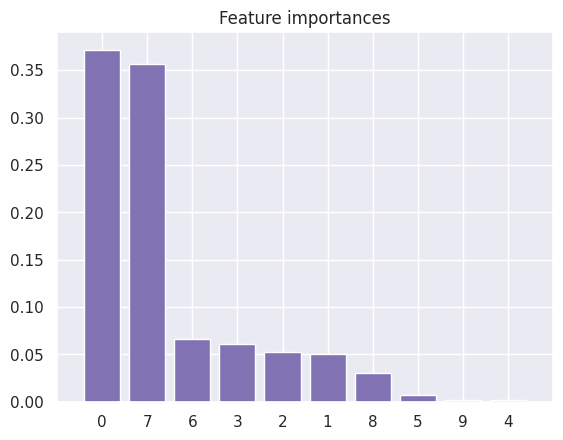

In [ ]:
def datetounix(df):
    unixtime = []

    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))

    df['DateTime'] = unixtime
    return(df)

tree_clf = ExtraTreesClassifier()

df_train_features = df_train.drop(['Vehicles'], axis=1)

df_train_features = datetounix(df_train_features)

X = df_train_features.values

y = df_train['Vehicles'].values

tree_clf.fit(X, y)

importances = tree_clf.feature_importances_
feature_names = df_train_features.columns.tolist()

feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

plt.figure(0)
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="m", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# **Traffic Histogram**

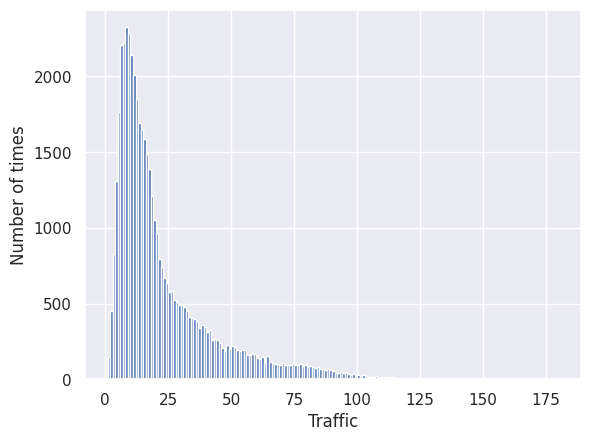

In [ ]:
data = df_train.Vehicles
binwidth = 1
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth), log=False)
plt.xlabel("Traffic")
plt.ylabel("Number of times")
plt.show()

# **Data preparation**

In [ ]:
df_test_features = datetounix(df_test.drop(['Year', 'Quarter', 'Month', 'ID'], axis=1))

X_test = df_test_features.values

df_train_features = df_train.drop(['Vehicles','Year', 'Quarter', 'Month', 'ID'], axis=1)

df_train_features = datetounix(df_train_features)

X = df_train_features.values

y = df_train['Vehicles'].values

# **1. Decision Tree Classifier**

In [ ]:
df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID

start_time = time.time()

clf = DecisionTreeClassifier(criterion='gini', random_state = 13)

clf.fit(X, y)

predictions = clf.predict(X_test)

print("Execution time is %s seconds." % (time.time() - start_time))

df_solution['Vehicles'] = predictions
df_solution

Execution time is 0.4378483295440674 seconds.


,ID,Vehicles
0,20170701001,70
1,20170701011,62
2,20170701021,52
3,20170701031,39
4,20170701041,40
...,...,...
11803,20171031194,30
11804,20171031204,30
11805,20171031214,16
11806,20171031224,22


import numpy as np
from google.colab import autoviz

def value_plot(df, y, sort_ascending=False, figscale=1):
  from matplotlib import pyplot as plt
  figsize = (8 * figscale, 4 * figscale)
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_solution, *['ID'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, sort_ascending=False, figscale=1):
  from matplotlib import pyplot as plt
  figsize = (8 * figscale, 4 * figscale)
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_solution, *['Vehicles'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  figsize = (8 * figscale, 4 * figscale)
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_solution, *['ID'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  figsize = (8 * figscale, 4 * figscale)
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_solution, *['Vehicles'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.6):
  from matplotlib import pyplot as plt
  figsize = (len(colname_pairs) * 10 * figscale, 10 * figscale)
  plt.figure(figsize=figsize)
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    # Note: `32*figscale` may be too large; scaling by # of datapoints may be
    # wiser.
    ax.scatter(df[x_colname], df[y_colname], s=(32 * figscale), alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_solution, *[[['ID', 'Vehicles']]], **{})
chart

# **2. XGBoost**

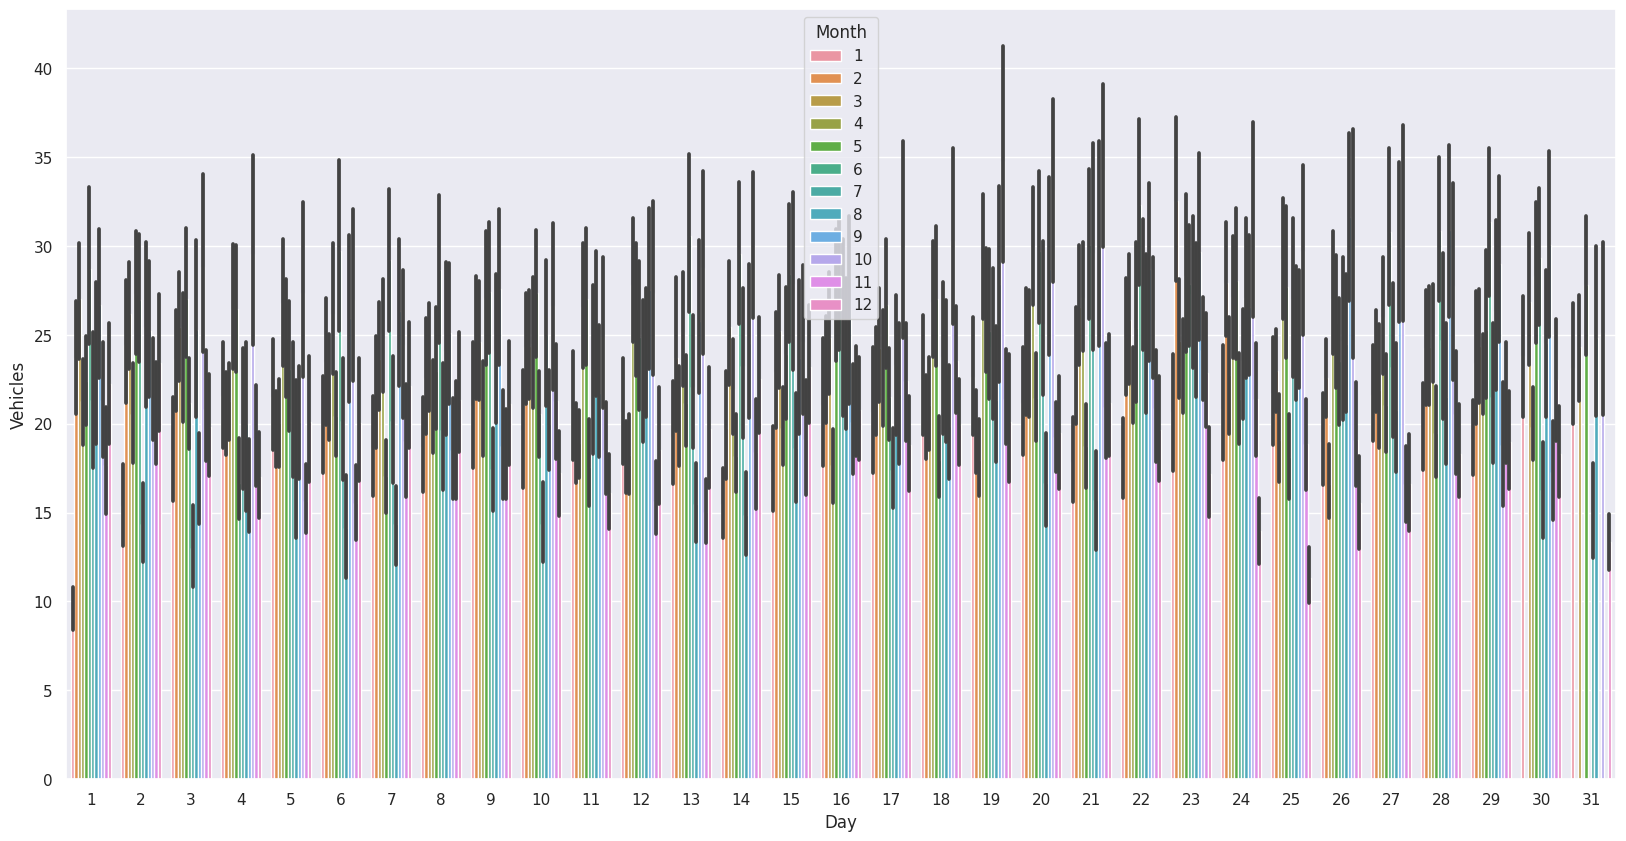

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="Day", y="Vehicles", hue='Month', data=df_train)

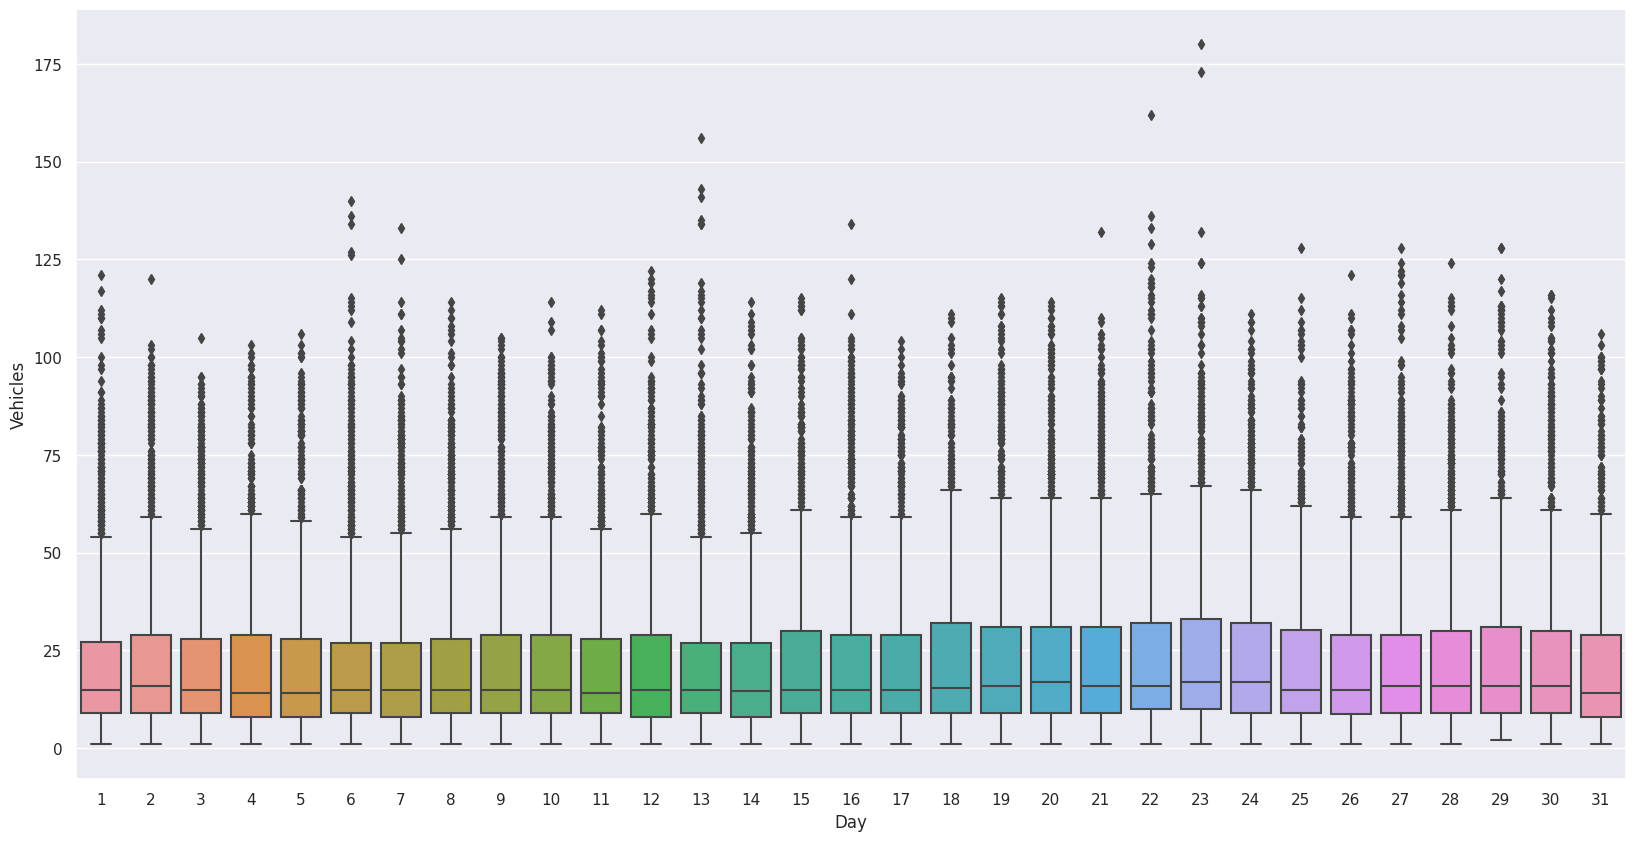

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="Day", y="Vehicles", data=df_train)

In [ ]:
test_3= df_test[df_test['Junction']==3]
test_others= df_test[df_test['Junction']!=3]

In [ ]:
y0 = df_train['Vehicles']
data0 = df_train[['Junction', 'Day', 'Month','Year']]
sub_test0 = test_3[['Junction', 'Day', 'Month','Year']]

In [ ]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', math.sqrt(mean_squared_error(labels, preds))

X_train, X_test, y_train, y_test = train_test_split(data0, y0, test_size=0.25, random_state=42)

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(sub_test0)

params = {
    "n_estimators": 300 ,
    "max_depth": 4 ,
    "learning_rate": 0.005 ,
    "colsample_bytree": 1 ,
    "subsample": 1 ,
    "gamma": 0.1 ,
    'reg_alpha': 10 ,
    "min_child_weight": 4 ,
    }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

reg = xgb.train(params, d_train, 1000, watchlist,  feval = evalerror, maximize=False, verbose_eval=50)

Vehicles_test_3 = reg.predict(d_test)

[12:32:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:30.49552	train-error:30.49553	valid-rmse:29.79594	valid-error:29.79594
[50]	train-rmse:24.77262	train-error:24.77262	valid-rmse:24.09586	valid-error:24.09586
[100]	train-rmse:20.53487	train-error:20.53487	valid-rmse:19.88503	valid-error:19.88503
[150]	train-rmse:17.46156	train-error:17.46156	valid-rmse:16.84801	valid-error:16.84801
[200]	train-rmse:15.29223	train-error:15.29223	valid-rmse:14.72361	valid-error:14.72361
[250]	train-rmse:13.79839	train-error:13.79839	valid-rmse:13.28490	valid-error:13.28490
[300]	train-rmse:12.79141	train-error:12.79141	valid-rmse:12.33644	valid-error:12.33644
[350]	train-rmse:12.13152	train-error:12.13152	valid-rmse:11.73009	valid-error:11.73009
[400]	train-rmse:11.70596	train-error:11.70596	valid-rmse:11.35164	valid-error:11.35164
[450]	train-rmse:11.43406	train-error:11.43406	valid-rmse:11.11877	valid-error:11.11877
[500]	train-rmse:11.26022	train-e

In [ ]:
y = df_train[df_train['Junction']!=3]['Vehicles']
data = df_train[df_train['Junction']!=3][['Junction', 'Day','Month','Year']]
sub_test = test_others[['Junction', 'Day', 'Month', 'Year']]

In [ ]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', math.sqrt(mean_squared_error(labels, preds))

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(sub_test)

params = {
    "n_estimators": 280 ,
    "max_depth": 3 ,
    "learning_rate": 0.005 ,
    "colsample_bytree": 1 ,
    "subsample": 1 ,
    "gamma": 0.1 ,
    'reg_alpha': 1 ,
    "min_child_weight": 2 ,
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

reg = xgb.train(params, d_train, 1000, watchlist,  feval = evalerror, maximize=False, verbose_eval=50)

Vehicles_test_others = reg.predict(d_test)

[12:32:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:34.52629	train-error:34.52629	valid-rmse:34.83809	valid-error:34.83809
[50]	train-rmse:28.01234	train-error:28.01234	valid-rmse:28.21584	valid-error:28.21583
[100]	train-rmse:23.17383	train-error:23.17383	valid-rmse:23.29495	valid-error:23.29495
[150]	train-rmse:19.64641	train-error:19.64641	valid-rmse:19.70573	valid-error:19.70573
[200]	train-rmse:17.13671	train-error:17.13671	valid-rmse:17.15196	valid-error:17.15196
[250]	train-rmse:15.38573	train-error:15.38573	valid-rmse:15.37737	valid-error:15.37737
[300]	train-rmse:14.17715	train-error:14.17715	valid-rmse:14.15863	valid-error:14.15863
[350]	train-rmse:13.35049	train-error:13.35049	valid-rmse:13.32849	valid-error:13.32849
[400]	train-rmse:12.78662	train-error:12.78662	valid-rmse:12.76486	valid-error:12.76486
[450]	train-rmse:12.40597	train-error:12.40597	valid-rmse:12.38728	valid-error:12.38728
[500]	train-rmse:12.14536	train-e

In [ ]:
ID_test_3= df_test[df_test['Junction']==3]['ID']
ID_test_others= df_test[df_test['Junction']!=3]['ID']

ID= pd.DataFrame()
ID= ID_test_others.append(ID_test_3)

Vehicles= pd.DataFrame()
Vehicles= np.concatenate((Vehicles_test_others,Vehicles_test_3))


prediction_4_months = pd.DataFrame({
        "ID": ID,
        "Vehicles": Vehicles
    })
prediction_4_months

,ID,Vehicles
0,20170701001,69.327644
1,20170701011,69.327644
2,20170701021,69.327644
3,20170701031,69.327644
4,20170701041,69.327644
...,...,...
8851,20171031193,19.937603
8852,20171031203,19.937603
8853,20171031213,19.937603
8854,20171031223,19.937603


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# **3. Random Forest Classifier**

In [ ]:
start_time = time.time()

# Preprocessing for train and test data
df_test_features = datetounix(df_test.drop(['Year', 'Quarter', 'Month', 'ID'], axis=1))
X_test = df_test_features.values

df_train_features = df_train.drop(['Vehicles', 'Year', 'Quarter', 'Month', 'ID'], axis=1)
df_train_features = datetounix(df_train_features)
X = df_train_features.values
y = df_train['Vehicles'].values

# Splitting the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on test set
predictions = clf.predict(X_test)

print("Execution time is %s seconds." % (time.time() - start_time))

# Create solution DataFrame
df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID
df_solution['Vehicles'] = predictions

# Display the solution DataFrame
print(df_solution)


# **4. LightGBM Classifier**

In [ ]:
start_time = time.time()

# Preprocessing for train and test data
df_test_features = datetounix(df_test.drop(['Year', 'Quarter', 'Month', 'ID'], axis=1))
X_test = df_test_features.values

df_train_features = df_train.drop(['Vehicles', 'Year', 'Quarter', 'Month', 'ID'], axis=1)
df_train_features = datetounix(df_train_features)
X = df_train_features.values
y = df_train['Vehicles'].values

# Splitting the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize LightGBM Classifier
clf = lgb.LGBMClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on test set
predictions = clf.predict(X_test)

print("Execution time is %s seconds." % (time.time() - start_time))

# Create solution DataFrame
df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID
df_solution['Vehicles'] = predictions

# Display the solution DataFrame
print(df_solution)

Execution time is 43.784910917282104 seconds.
                ID  Vehicles
0      20170701001        38
1      20170701011        25
2      20170701021        25
3      20170701031        25
4      20170701041        25
...            ...       ...
11803  20171031194         5
11804  20171031204         5
11805  20171031214         5
11806  20171031224         5
11807  20171031234         5

[11808 rows x 2 columns]


# **5. LSTM**

In [ ]:
start_time = time.time()

# Preprocessing for train and test data
df_test_features = datetounix(df_test.drop(['Year', 'Quarter', 'Month', 'ID'], axis=1))
X_test = df_test_features.values

df_train_features = df_train.drop(['Vehicles', 'Year', 'Quarter', 'Month', 'ID'], axis=1)
df_train_features = datetounix(df_train_features)
X = df_train_features.values
y = df_train['Vehicles'].values

# Splitting the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Initialize LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict on test set
predictions = model.predict(X_test)

print("Execution time is %s seconds." % (time.time() - start_time))

# Create solution DataFrame
df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID
df_solution['Vehicles'] = predictions.flatten()

# Display the solution DataFrame
print(df_solution)

Epoch 1/20
1128/1128 [==============================] - 30s 18ms/step - loss: 321.5499 - val_loss: 112.4059
Epoch 2/20
1128/1128 [==============================] - 9s 8ms/step - loss: 105.0139 - val_loss: 86.1766
Epoch 3/20
1128/1128 [==============================] - 5s 5ms/step - loss: 82.1485 - val_loss: 69.0415
Epoch 4/20
1128/1128 [==============================] - 4s 4ms/step - loss: 64.0071 - val_loss: 57.9505
Epoch 6/20
1128/1128 [==============================] - 5s 5ms/step - loss: 59.6346 - val_loss: 54.0616
Epoch 7/20
1128/1128 [==============================] - 7s 6ms/step - loss: 55.2600 - val_loss: 50.5914
Epoch 8/20
1128/1128 [==============================] - 5s 4ms/step - loss: 51.6579 - val_loss: 47.6063
Epoch 9/20
1128/1128 [==============================] - 6s 5ms/step - loss: 49.0238 - val_loss: 45.4123
Epoch 10/20
1128/1128 [==============================] - 7s 6ms/step - loss: 47.0111 - val_loss: 43.7394
Epoch 11/20
1128/1128 [==============================] - 5